# WORKING WITH IMAGES AND LOGISTIC REGRESSION IN PYTORCH


## Introduction to Deep Learning using PyTorch

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Installing all the required modules and classes
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

We can download the data and create a PyTorch dataset using the MNIST class from torchvision.datasets

In [4]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Let's look at an image from the dataset. The images are converted to PyTorch tensors with the shape 1x28x28 (the dimensions represent color channels, width and height). However, plt.imshow expects channels to be last dimension in an image tensor, so we use the permute method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
Label: 5


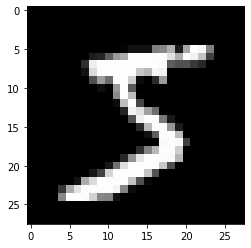

In [5]:
image, label = dataset[0] 
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [6]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We now create PyTorch data loaders for training and validation.

In [7]:
batch_size=128

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Let's visualize a batch of data in a grid using the make_grid function from torchvision. 
We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

C:\Users\ML\miniconda3\envs\ML_env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


images.shape: torch.Size([128, 1, 28, 28])


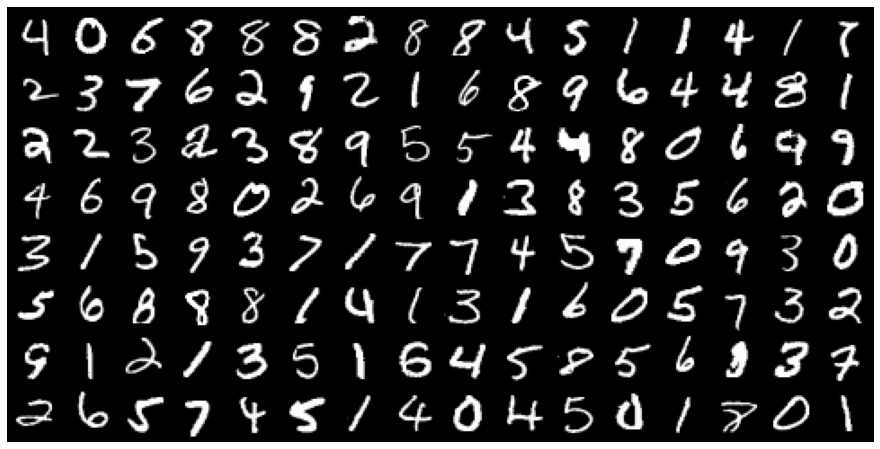

In [9]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden layers,Activation functions and Non Linearity

We'll create a neural network with two layers: a hidden layer and an output layer. Additionally, we'll use an activation function between the two layers..

First, let's create a batch of inputs tensors. We'll flatten the 1x28x28 images into vectors of size 784, so they can be passed into an nn.Linear object.

In [10]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [11]:
input_size = inputs.shape[-1]
hidden_size = 32

In [12]:
layer1 = nn.Linear(input_size, hidden_size)

In [13]:
inputs.shape

torch.Size([128, 784])

In [14]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size 784 are transformed into intermediate output vectors of length 32 by performing a matrix multiplication of inputs matrix with the transposed weights matrix of layer1 and adding the bias.

In [15]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape


torch.Size([128, 32])

In [16]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [17]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to layer1_outputs and verify that negative values were replaced with 0

In [18]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7633729577064514
min(relu_outputs): 0.0


Now that we've applied a non-linear activation function, relu_outputs and inputs do not have a linear relationship.

Next, let's create an output layer to convert vectors of length hidden_size in relu_outputs into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [19]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)


In [20]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [21]:
inputs.shape

torch.Size([128, 784])

layer2_outputs contains a batch of vectors of size 10. We can now use this output to compute the loss using F.cross_entropy and adjust the weights of layer1 and layer2 using gradient descent.

In [22]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3131, grad_fn=<NllLossBackward>)

In [23]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [24]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [25]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [26]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [27]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [28]:
torch.allclose(outputs2, outputs3, 1e-3)

False

## MODEL

We'll create a neural network with one hidden layer. Here's what that means:

Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects.

The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size.

We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.

The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.

In [29]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [32]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers

In [33]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.



In [34]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3101894855499268
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0312,  0.0249,  0.1686,  0.0382,  0.2051, -0.1115,  0.0928, -0.0784,
          0.1380, -0.0477],
        [ 0.0466, -0.0534,  0.1431, -0.0005,  0.1218, -0.1066,  0.0217, -0.1397,
          0.0532,  0.0645]])


In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [36]:
device = get_default_device()
device

device(type='cpu')

In [37]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [38]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


We define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device.

In [39]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [41]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([7, 5, 6, 9, 6, 7, 7, 4, 1, 1, 4, 4, 2, 5, 2, 3, 6, 9, 4, 1, 0, 6, 2, 5,
        8, 6, 5, 1, 1, 9, 8, 1, 9, 5, 7, 4, 1, 4, 3, 6, 8, 2, 1, 6, 2, 7, 6, 7,
        0, 6, 5, 9, 7, 7, 1, 1, 1, 0, 0, 7, 8, 8, 5, 5, 2, 9, 0, 2, 7, 4, 7, 7,
        8, 0, 7, 0, 8, 9, 7, 8, 7, 7, 1, 6, 0, 4, 6, 6, 5, 4, 9, 4, 5, 9, 8, 9,
        1, 3, 2, 7, 1, 6, 6, 9, 4, 5, 2, 7, 5, 0, 9, 6, 7, 7, 9, 0, 7, 5, 0, 6,
        8, 3, 1, 9, 3, 4, 8, 6, 0, 1, 0, 2, 9, 2, 6, 6, 7, 3, 1, 4, 6, 7, 5, 5,
        1, 1, 3, 3, 3, 9, 5, 2, 8, 3, 6, 0, 4, 5, 2, 5, 2, 6, 5, 1, 0, 7, 9, 5,
        5, 0, 4, 0, 5, 8, 2, 9, 2, 3, 9, 5, 2, 5, 3, 2, 0, 7, 8, 0, 8, 2, 2, 5,
        1, 1, 0, 9, 6, 1, 4, 4, 8, 9, 2, 6, 8, 0, 6, 8, 5, 3, 6, 7, 2, 2, 9, 7,
        8, 7, 7, 3, 5, 2, 4, 1, 9, 6, 0, 3, 0, 0, 4, 2, 3, 5, 7, 1, 5, 6, 7, 7,
        4, 4, 8, 6, 6, 8, 1, 2, 2, 4, 5, 5, 0, 9, 7, 8])


## Training the Model

We'll define two functions: fit and evaluate to train the model using gradient descent and evaluate its performance on the validation set.

In [42]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

We will see how the model performs on the validation set with the initial set of weights and biases.

In [44]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3145735263824463, 'val_acc': 0.05400390550494194}]

The initial accuracy is around 5%, as one might expect from a randomly initialized model.

Let's train the model for five epochs and look at the results.

In [45]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2201, val_acc: 0.9329
Epoch [1], val_loss: 0.1805, val_acc: 0.9469
Epoch [2], val_loss: 0.1727, val_acc: 0.9490
Epoch [3], val_loss: 0.1524, val_acc: 0.9552
Epoch [4], val_loss: 0.1355, val_acc: 0.9606


In [46]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1206, val_acc: 0.9664
Epoch [1], val_loss: 0.1212, val_acc: 0.9650
Epoch [2], val_loss: 0.1212, val_acc: 0.9646
Epoch [3], val_loss: 0.1199, val_acc: 0.9661
Epoch [4], val_loss: 0.1201, val_acc: 0.9652


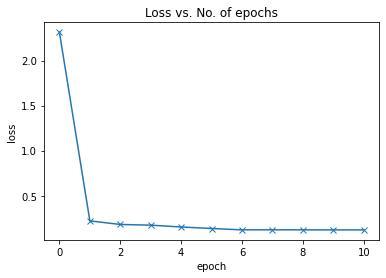

In [47]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

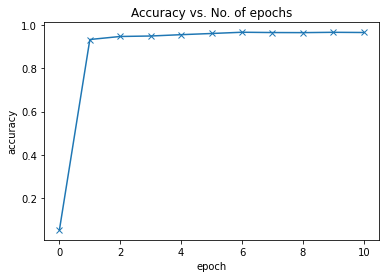

In [48]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model.It quickly reaches an accuracy of 97% but doesn't improve much beyond this. To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations.

## Testing with images

In [49]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [50]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


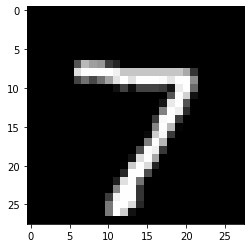

In [51]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


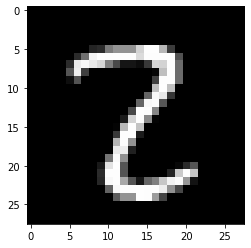

In [52]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


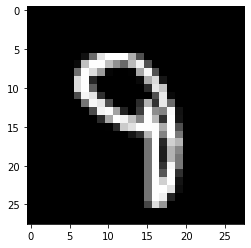

In [53]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set.

In [54]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10581312328577042, 'val_acc': 0.969433605670929}